In [17]:
import torch
import os
import time
import math
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torch.autograd import grad
from torch.nn import Parameter
cuda = torch.cuda.is_available()
from google.colab import drive
import pickle as pk
from torchsummary import summary
# NN Architecture
## all layers that we want to use are in package nn and we can use as many layers as we want
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

torch.cuda.is_available()

True

In [18]:
# we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, 
# ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, 
# i.e. 3-channel color images of 32x32 pixels in size.

batch_size = 64

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=len(train_data))

batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean, std)
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64])


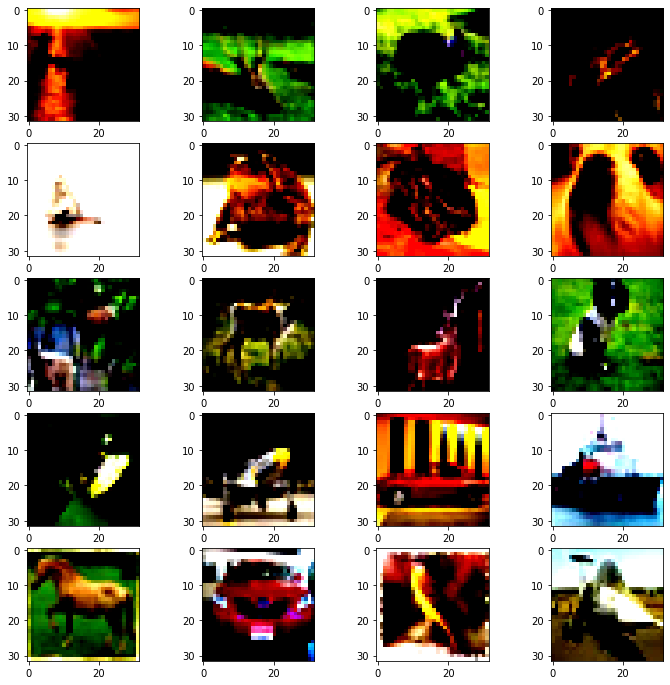

In [19]:
print(images.shape)
print(labels.shape)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    idx = np.random.randint(0, 64)
    fig.add_subplot(rows, columns, i)
    npimg = images[i].numpy()
    np.clip(npimg, 0, 1, out=npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()



# Cool theoretical staff that I want to keep near my code
Rule of thumb for “in_channels” on your first Conv2d layer:

— If your image is black and white, it is 1 channel. (You can ensure this by running transforms.Grayscale(1) in the transforms argument of the dataloader.)

— If your image is color, it is 3 channels (RGB).

— If there is an alpha (transparency) channel, it has 4 channels.

For each convolutional kernel you use, your output tensor becomes one channel deeper when passing through that layer. Convolutional layers at the front half of a network get deeper and deeper, while fully-connected (aka: linear, or dense) layers at the end of a network get smaller and smaller.

I know these look similar, but do not be confused: “in_features” and “in_channels” are completely different, beginners often mix them up and think they’re the same attribute.

Asks for in_channels, out_channels, kernel_size, etc
self.conv1 = nn.Conv2d(1, 20, 3)

Asks for in_features, out_features
self.fc1 = nn.Linear(2048, 10)


If you want to pass in your 28 x 28 image into a linear layer, you have to know two things:

Your 28 x 28 pixel image can’t be input as a [28, 28] tensor. This is because nn.Linear will read it as 28 batches of 28-feature-length vectors. Since it expects an input of [batch_size, num_features], you have to transpose it somehow 


Your batch size passes unchanged through all your layers. 

No matter how your data changes as it passes through a network, your first dimension will end up being your batch_size even if you never see that number explicitly written anywhere in your network module’s definition.


Remember this — if you’re ever transitioning from a convolutional layer output to a linear layer input, you must resize it from 4d to 2d using view, as described with image example above.
So, a conv output of [32, 21, 50, 50] should be “flattened” to become a [32, 21 * 50 * 50] tensor. And the in_features of the linear layer should also be set to [21 * 50 * 50].

In [20]:
# ResNet uses blocks
class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResNetBlock, self).__init__()
    self.kernel_size = 3
    
    # structure
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, stride=1, padding=1)
    self.relu1 = nn.LeakyReLU()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, stride=1, padding=1)
    self.relu2 = nn.LeakyReLU()
    self.bn2 = nn.BatchNorm2d(in_channels)
    self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, stride=1, padding=1)
    self.relu3 = nn.LeakyReLU()
    self.bn3 = nn.BatchNorm2d(in_channels)
    self.conv4 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels * 2, kernel_size=self.kernel_size, stride=2, padding=(32 - 15))
    self.relu4 = nn.LeakyReLU()
    self.bn4 = nn.BatchNorm2d(in_channels * 2)

    # 1x1 conv filters can be used to change the dimensionality in the filter space.
    self.identity_upsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels * 2, kernel_size=1, stride=1),
                                      nn.BatchNorm2d(in_channels * 2))
    #self.identity_downsample = nn.Sequential(nn.Conv2d(in_channels=out_channels * 2, out_channels=in_channels, kernel_size=1, stride=1), nn.BatchNorm2d(in_channels))

  def forward(self, x):
    # we use this block multipy times
    # DEBUG
    #print(f'x forward start: {x.shape}')

    # save first identity
    identity1 = x.clone()

    x = self.conv1(x)
    x = self.relu1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.bn2(x)

    # sum point
    x = x + identity1

    # save second identity and change size to be able to summurize in the next sum point
    identity_upsampled = self.identity_upsample(x)
    # DEBUG
    #print(f'identity_upsample : {identity_upsampled.shape}')

    x = self.conv3(x)
    x = self.relu3(x)
    x = self.bn3(x)
    x = self.conv4(x)
    x = self.relu4(x)
    x = self.bn4(x)

    # DEBUG
    #print(f'x for last sum point: {x.shape}')  

    # sum point
    x = x + identity_upsampled
    return x
  
block = ResNetBlock(in_channels=16, out_channels=16)
block

ResNetBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.01)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(17, 17))
  (relu4): LeakyReLU(negative_slope=0.01)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (identity_upsample): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
# # 2d: [batch_size, num_features (aka: C * H * W)]
# use for nn.Linear() input.

class ResNet(nn.Module): 
  # layers is the list telling us how much to reuse the block in each block
  def __init__(self, block, N, image_channel, num_classes, batch_size=64):
    super(ResNet, self).__init__()
    self.in_channels = 16
    self.kernel_size = 3
    self.start_identity = None
    self.linear_size = 131072
    self.batch_size = batch_size
    self.batch_small = 2
    self.N = N

    # Begin
    self.conv1 = nn.Conv2d(in_channels=image_channel, out_channels=16, kernel_size=self.kernel_size, stride=1, padding=1)
    self.relu1 = nn.LeakyReLU()
    self.bn1 = nn.BatchNorm2d(16)

    # ResNet Layers
    # repeat 3 times for i in range(2)
    # out_channel is equal to 16 * 2 * i => 16*2^0, 16*2^1, 16*2^2 => 16, 32 and 64 out_channels
    self.layer1 = self.make_layer(block, self.N, out_channels=16)
    self.layer2 = self.make_layer(block, self.N, out_channels=32)
    self.layer3 = self.make_layer(block, self.N, out_channels=64)
    
    # End
    self.fc_10 = nn.Linear(in_features=131072, out_features=num_classes)

  def forward(self, x):
    
    # Begin 
    x = self.conv1(x)
    x = self.bn1(x)

    # ResNet Layers forward step
    # loops inside every layer
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #print('\nExit looped structure')
    
    # End
    #print(f'\nafter layers structure: {x.shape}')    
    if x.shape[0] == self.batch_size:
      x = x.view(self.batch_size, -1)
    else:
      x = x.view(x.shape[0], -1)
    #print(f'\nafter view(): {x.shape}')

    x = self.fc_10(x)
    #print(f'after fc_10: {x.shape}')
       
    return x
    
  def make_layer(self, block, num_residual_blocks, out_channels):
    identity_downsample = None
    layers = []

    print(f'Extern loop START')
    layers.append(block(self.in_channels, out_channels))
    self.in_channels = out_channels * 2

      # intern loops for layers and skip connections
    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))
      print(f'Inner layer {n} is created!')

    print(f'Extern loop END')
    return nn.Sequential(*layers)


# ==========================
my_net = ResNet(ResNetBlock, 1, image_channel=3, num_classes=10, batch_size=64)
my_net.cuda()

Extern loop START
Extern loop END
Extern loop START
Extern loop END
Extern loop START
Extern loop END


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): LeakyReLU(negative_slope=0.01)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): LeakyReLU(negative_slope=0.01)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): LeakyReLU(negative_slope=0.01)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(17, 1

In [22]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion,
          train_data: DataLoader, max_epoch: int, cuda = torch.cuda.is_available()):

  losses = []
  batch_total = len(train_data)

  for epoch in range(max_epoch):  # loop over the dataset multiple times
    samples_total = 0
    samples_correct = 0
    samples_correct_test = 0

    running_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = batch
      if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      output = model(inputs)
      
      # DEBUG
      #print(f'Input shape: {inputs.shape}')
      #print(f'Output shape: {output.shape}')
      #print(f'Labels: {labels}')
      #print(f'Labels shape: {labels.shape}')
      #print(f'\nIndex: {batch_idx}, len of batch: {len(batch[0])}')
      
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      yhat = torch.argmax(output, dim=1)

      samples_total += len(labels)
      samples_correct += torch.sum(yhat == labels)
      losses.append(loss.item())

      # print statistics
      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)

        sys.stdout.write(f'\repoch: {epoch} / {max_epoch} Step: {batch_idx}/{batch_total}, Loss: {loss.item():.6f}, Acc: {acc:.2%}')

  print('\nFinished Training')
  return losses

In [23]:
# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#print(len(train_loader))

start = time.time()
cifar_losses = train(my_net, optimizer, criterion, train_loader, max_epoch=10)
end = time.time()
print(f'\nTraining took {end - start}s')


Saved some records

epoch: 0 / 10 Step: 200/782, Loss: 1.498694, Acc: 33.08%

epoch: 0 / 10 Step: 500/782, Loss: 1.373553, Acc: 43.27%

epoch: 2 / 10 Step: 650/782, Loss: 0.905583, Acc: 70.56%

epoch: 5 / 10 Step: 200/782, Loss: 0.581659, Acc: 85.49%

epoch: 7 / 10 Step: 200/782, Loss: 0.240940, Acc: 92.20%

epoch: 9 / 10 Step: 350/782, Loss: 0.125062, Acc: 95.67%

epoch: 9 / 10 Step: 750/782, Loss: 0.059952, Acc: 96.79%
Finished Training

Training took 570.6231439113617s




